# Imports and Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

two_pi = 2*pi

def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, two_pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

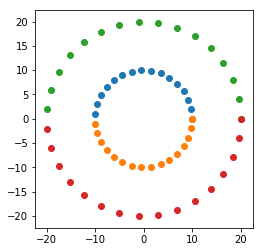

In [2]:
r = [10, 20]
n = [32, 32]
circles = circle_points(r, n)

fig, ax = plt.subplots()
ally_label = 0
advr_label = 0

X, y_ally, y_advr = [], [], []

for circle in circles:
    pos = circle[np.where(circle[:, 1]>= 0)]
    neg = circle[np.where(circle[:, 1]< 0)]
    X.append(pos)
    X.append(neg)
    y_ally.append([ally_label] * circle.shape[0])
    y_advr.append([advr_label] * pos.shape[0] + [advr_label+1] * neg.shape[0])
    ax.scatter(pos[:, 0], pos[:, 1])
    ax.scatter(neg[:, 0], neg[:, 1])
    ally_label += 1
ax.set_aspect('equal')
plt.show()


### Idea

Basically we are trying to learn represenations of any given data in another transformed axes where classification becomes easier along one label but becomes tougher along another one.

- Here we want to differentiate between the two circles while not being able to tell between the two semicircles

In [3]:
X = np.concatenate(X, axis=0)
y_ally = np.concatenate(y_ally)
y_advr = np.concatenate(y_advr)
X.shape, y_ally.shape, y_advr.shape

((64, 2), (64,), (64,))

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

### Validation after scaling

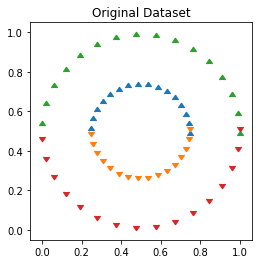

In [5]:
def class_plot(X_input, aspect=True, title=False):
    fig, ax = plt.subplots()
    markers = [6, 7, 6, 7]
    for i in range(2):
        for j in range(2):
            tmp = X_input[np.intersect1d(np.where(y_ally == i), np.where(y_advr == j))]
            ax.scatter(tmp[:, 0], tmp[:, 1], marker=markers[2*i+j])
    if aspect:
        ax.set_aspect('equal')
    if title:
        plt.title(title)
    plt.show()
    
class_plot(X_normalized, title="Original Dataset")

# PCA

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_normalized)

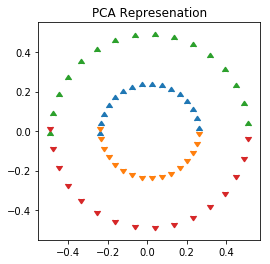

In [7]:
class_plot(X_pca, title='PCA Represenation')

# AutoEncoder

In [8]:
import torch

In [9]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        self.hidden_size = hidden_size
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        self.fc11 = torch.nn.Linear(self.hidden_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.hidden_size)
        self.sigmoid = torch.nn.Sigmoid()
        
        
        self.fc22 = torch.nn.Linear(self.hidden_size, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.sigmoid(self.fc11(self.sigmoid(self.fc1(x))))

    def decoder(self, y):
        return self.sigmoid(self.fc22(self.sigmoid(self.fc2(y))))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [10]:
auto_encoder = AutoEncoder(input_size=X.shape[1],encoding_dim=X_pca.shape[1], hidden_size=X_pca.shape[1]*2)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.1)

In [11]:
X_torch = torch.Tensor(X_normalized)
y_ally_torch = torch.Tensor(y_ally.reshape(-1, 1))
y_advr_torch = torch.Tensor(y_advr.reshape(-1, 1))

epoch 	 Aencoder_train
0 	 0.12457398
100 	 0.04277601
200 	 0.00393008
300 	 0.00123744
400 	 0.00085871
500 	 0.00104232
600 	 0.00041605
700 	 0.00034732
800 	 0.00031070
900 	 0.00048388
1000 	 0.00025595


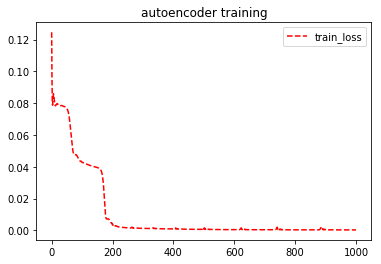

In [12]:
print("epoch \t Aencoder_train")

ae_epoch = []
ae_train = []

for epoch in range(1001):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_torch_hat = auto_encoder(X_torch)
    ae_loss = criterion(X_torch_hat, X_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    
    if epoch%100!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
    ))
    

plt.plot(ae_epoch, ae_train, 'r--')
plt.legend(['train_loss'])
plt.title("autoencoder training")
plt.show()

In [13]:
X_autoencoded = auto_encoder.encoder(X_torch)

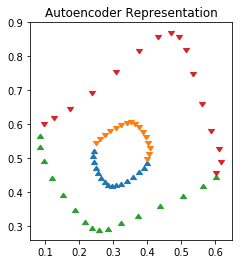

In [14]:
class_plot(X_autoencoded.detach().numpy(), title='Autoencoder Representation')

In [15]:
X_autodecoded = auto_encoder.decoder(X_autoencoded)

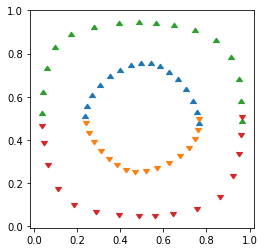

In [16]:
class_plot(X_autodecoded.detach().numpy())

# Privacy GAN

In [82]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [85]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = X_pca.shape[1]
    encoder = Encoder(
        input_size=X_torch.shape[1], 
        hidden_size=encoding_dimension*2, 
        output_size=encoding_dimension)
    ally = Ally(
        input_size=encoding_dimension, 
        hidden_size=encoding_dimension*2, 
        output_size=y_ally_torch.shape[1])
    adversary = Adversary(
        input_size=encoding_dimension, 
        hidden_size=encoding_dimension*2, 
        output_size=y_advr_torch.shape[1])

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_optimizer = optimizer(adversary.parameters(), lr=lr_advr)

    if debug:
        print("epoch \t encoder_train \t ally_train \t advr_train")

    g_epoch = []
    enc_train = []
    ally_train = []
    advr_train = []
    
    encoder.train()
    ally.train()
    adversary.train()

    for epoch in range(n_iter_gan):
        # set for training
        # Forward passv
        X_ganencoded = encoder(X_torch)
        y_ally_torch_hat = ally(X_ganencoded)
        y_advr_torch_hat = adversary(X_ganencoded)
        # Compute Loss
        ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
        advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
        encd_loss = ally_loss - advr_loss
        # Backward pass
        
        encd_optimizer.zero_grad()
        encd_loss.backward()
        encd_optimizer.step()

        for i in range(d_reps):
            X_ganencoded = encoder(X_torch)
            y_ally_torch_hat = ally(X_ganencoded)
            ally_optimizer.zero_grad()
            ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
            ally_loss.backward()
            ally_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_torch_hat = adversary(X_ganencoded)
            advr_optimizer.zero_grad()
            advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
            advr_loss.backward()
            advr_optimizer.step()

        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            ally_train.append(ally_loss.item())
            advr_train.append(advr_loss.item())
            
        if epoch%500!=0 and (debug or plot):
            continue

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                ally_loss.item(),
                advr_loss.item(),
            ))
        
        X_ganencoded = encoder(X_torch)
        class_plot(X_ganencoded.detach().numpy(), False)

    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, advr_train, 'g')
        plt.legend([
            'encoder train loss', 
            'ally train loss',
            'advr train loss',
        ])
        plt.title("GAN training")
        plt.show()            

        return encoder  

- maximize the divergence
- no dimensionality reduction here

epoch 	 encoder_train 	 ally_train 	 advr_train
0 	 -0.01345831 	 0.72445375 	 0.73793113


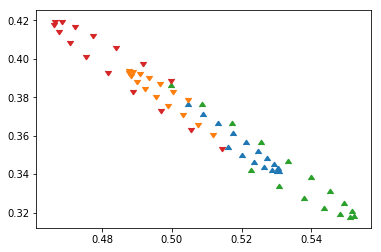

500 	 -0.01525760 	 0.68026423 	 0.69554818


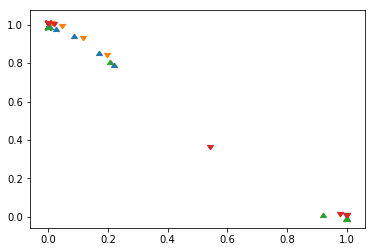

1000 	 -0.03997153 	 0.65359813 	 0.69358683


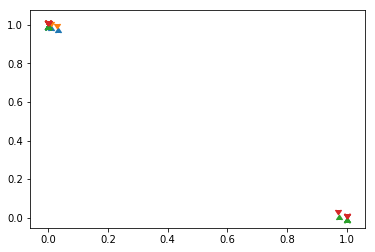

1500 	 -0.05061066 	 0.64269519 	 0.69331211


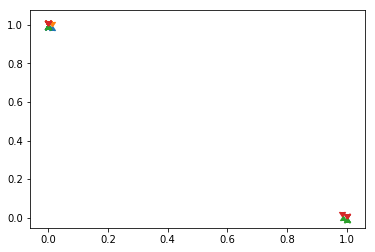

2000 	 -0.05477679 	 0.63844532 	 0.69322491


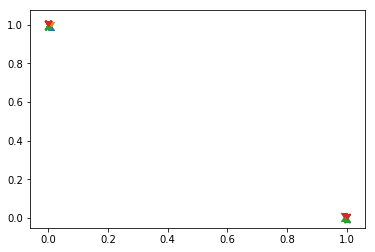

2500 	 -0.05673122 	 0.63645518 	 0.69318777


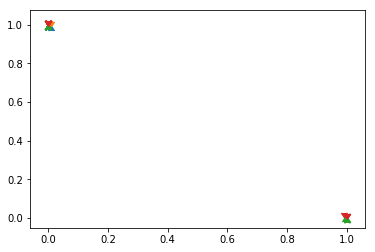

3000 	 -0.05777258 	 0.63539636 	 0.69316971


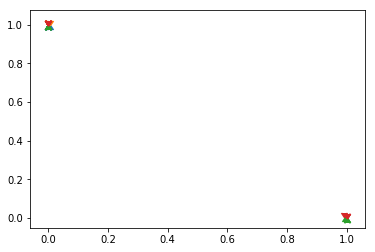

3500 	 -0.05837154 	 0.63478792 	 0.69315994


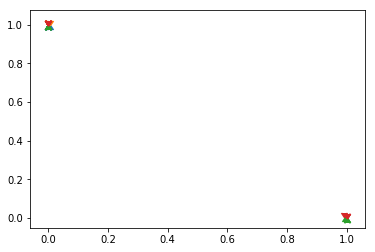

4000 	 -0.05873287 	 0.63442153 	 0.69315469


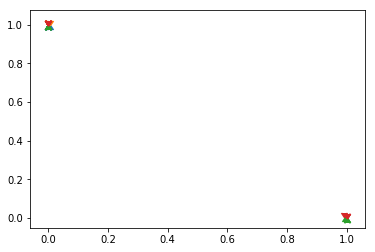

4500 	 -0.05895698 	 0.63419420 	 0.69315153


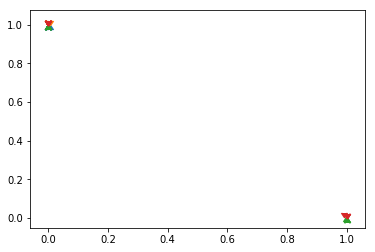

5000 	 -0.05909902 	 0.63405079 	 0.69314981


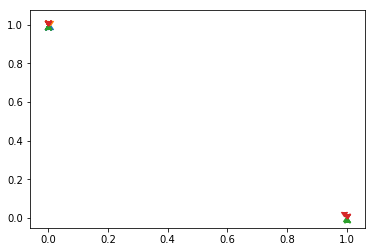

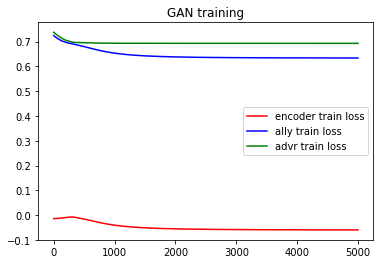

In [88]:
alpha = 0.5
lr_encd = 0.01
lr_ally = 0.001
lr_advr = 0.001
n_iter_gan = 5001
d_reps = 2

# alpha = 0.5
# lr_encd = 0.01
# lr_ally = 0.001
# lr_advr = 0.0001
# n_iter_gan = 5001
# d_reps = 2


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

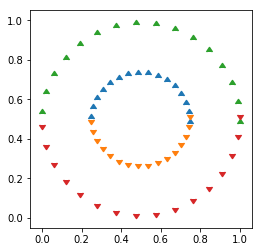

In [60]:
class_plot(X_normalized)

# DP

In [299]:
def laplaceMechanism(x, epsilon):
    return x + np.random.laplace(0, 1.0/epsilon, x.shape)

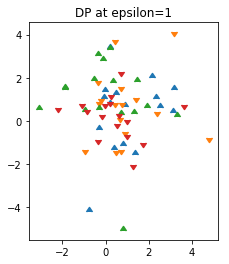

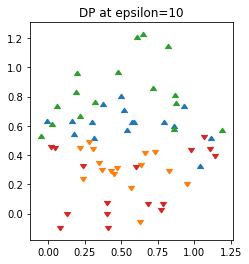

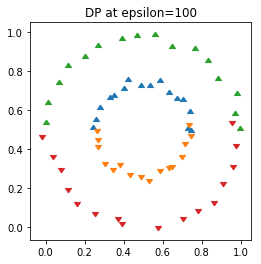

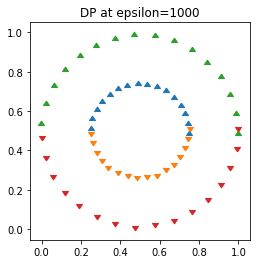

In [337]:
epsilons = [1, 10, 100, 1000]
for epsilon in epsilons:
    X_dp = laplaceMechanism(X_normalized, epsilon)

    class_plot(X_dp, title="DP at epsilon={}".format(epsilon))

In [297]:
np.random.laplace(0, 1.0/100000, X_dp.shape)

array([[-4.72552465e-06, -6.59614578e-06],
       [-1.86612074e-06,  2.87500383e-06],
       [ 2.26070135e-05,  8.30682609e-06],
       [ 1.45351421e-05,  5.79004018e-06],
       [ 7.40990572e-08,  1.17819188e-05],
       [ 1.33496303e-05,  3.16996342e-05],
       [ 3.28095664e-07,  8.67730517e-07],
       [-2.70105368e-05,  1.57426635e-05],
       [-1.09582595e-05,  3.15502634e-06],
       [ 2.48496620e-05, -7.64952951e-06],
       [-2.80048844e-06, -3.29326376e-06],
       [ 6.25928190e-06, -8.53314256e-06],
       [-1.64662458e-05, -4.00245945e-06],
       [ 6.26190766e-06,  6.95627223e-06],
       [-7.31365951e-06, -2.35163486e-05],
       [ 4.70697350e-06,  1.19689964e-05],
       [ 4.18826603e-06,  3.51923087e-06],
       [-1.60851220e-05,  1.76578012e-05],
       [ 2.23254776e-06, -1.22961546e-05],
       [-2.19947051e-06, -6.91126851e-07],
       [-1.59020046e-05,  1.54967672e-06],
       [ 2.57763357e-07,  5.07819904e-06],
       [ 2.67790980e-06, -6.56846004e-07],
       [ 2.